In [1]:
import freud
import gsd
import gsd.pygsd
import gsd.hoomd
import signac
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components
from scipy.interpolate import InterpolatedUnivariateSpline
from collections import defaultdict
from collections import OrderedDict
from collections import Counter

In [3]:
def snap_bond_graph(snap):
    """ 
    Given a snapshot from a trajectory return an array
    corresponding to the molecule index of each particle
    Parameters
    ----------
    snap : gsd.hoomd.Snapshot
    Returns
    -------
    numpy array (N_particles,)
    """
    bond_graph = csr_matrix(
        (np.ones(snap.bonds.N), (snap.bonds.group[:,0],snap.bonds.group[:,1])),
        shape=(snap.particles.N,snap.particles.N))   
    n_components, labels = connected_components(csgraph=bond_graph, directed=False)
    return labels

class Molecule:
    def __init__(self, id_num, molecules):
        self.molecule_id = id_num
        self.atom_indices = np.where(molecules == self.molecule_id)[0]
        self.surface_pos = []
        self.surface_frames = []
        self.active_site_types = []
        self.active_site_frames = []
        self.hit_counter = 0
        
    def atom_types(self, frame):
        type_ids = [frame.particles.typeid[self.atom_indices]]
        atoms = [frame.particles.types[typeid] for typeid in type_ids]
        return atoms
    
    def center_xyz(self, frame):
        positions = frame.particles.position[self.atom_indices]
        molecule_center = np.mean(positions, axis=0)
        return molecule_center
     
    def log_molecule(self, frame_num, frame, system, dist_cutoff=0.6):
        '''
        Creates a new list for each new surface interaction
        That list contains positions for all consecutive frames
        that the molecule stays on the surface
        I'm allowing a bit of a buffer, if a molecule is off the surface for a single
        frame between 2 frames where it is on the surface, its all counted as the same surface
        interaction.
        '''
        try:
            last_frame = self.surface_frames[-1][-1]
            if last_frame >= frame_num -2: # -2 is the buffer
                self.surface_frames[-1].append(frame_num)
                self.surface_pos[-1].append(self.center_xyz(frame))
            else: # New interaction, append an empty list, then start appending positions
                self.surface_frames.append([])
                self.surface_pos.append([])
                self.surface_frames[-1].append(frame_num)
                self.surface_pos[-1].append(self.center_xyz(frame))
        except:
            self.surface_frames.append([frame_num])
            self.surface_pos.append([self.center_xyz(frame)])
            
        active_site = active_site_hit(self.center_xyz(frame), system.active_sites, dist_cutoff)
        if active_site:
            self.hit_counter += 1
            try:
                last_frame = self.active_site_frames[-1][-1]
                if last_frame >= frame_num -1:
                    self.active_site_frames[-1].append(frame_num)
                    #self.surface_pos[-1].append(self.center_xyz(frame))
                else: # New interaction, append an empty list, then start appending positions
                    self.active_site_frames.append([])
                    #self.surface_pos.append([])
                    self.active_site_frames[-1].append(frame_num)
                    #self.surface_pos[-1].append(self.center_xyz(frame))
            except:
                self.active_site_frames.append([frame_num])
                #self.surface_pos.append([self.center_xyz(frame)])
            
    def molecule_msd(self, system_box):
        self.avg_msd = average_mol_msd(self, box=system_box)
        
    #########################################################################
    
class System:
    
    def __init__(self, system, unit_cell_repeats):
        self.system = system
        self.x_repeat = unit_cell_repeats[0]
        self.y_repeat = unit_cell_repeats[1]
        self.z_repeat = unit_cell_repeats[2]
        self.molecule_labels = snap_bond_graph(self.system)
        self.mol_count_dict = Counter(self.molecule_labels)
        self.box = system.configuration.box
        self.surface_atoms = self.surface(self.system)
        self.configuration = self.find_box_configuration(self.system)
        self.top_surface, self.bottom_surface = self.surface_z_values(self.system)
        self.active_sites = self.find_active_sites()
        # active site stuff here
        
    def molecules(self, stoich_dict):
        # number of atoms in the molecule
        dict_atoms = []
        for key in stoich_dict:
            dict_atoms.extend([key for i in range(stoich_dict[key])])
        dict_atoms.sort()
        # narrow down IDs by length (length of ID == num of atoms in that id)
        molecule_ids = [key for key in self.mol_count_dict if self.mol_count_dict[key] == len(dict_atoms)]
        molecule_ids_keep = []
        
        for mol_id in molecule_ids:
            atom_indices = np.where(self.molecule_labels == mol_id)[0]
            type_ids = list(self.system.particles.typeid[atom_indices])
            atoms = [self.system.particles.types[typeid] for typeid in type_ids]
            atoms.sort()
            if atoms == dict_atoms:
                molecule_ids_keep.append(mol_id)
                
        return [Molecule(i, self.molecule_labels) for i in molecule_ids_keep]
    
    def find_box_configuration(self, system):
        '''
        Determine if the system is set up in either of 2 possible configurations
        Box: The two surfaces are situated at the top and bottom of the system.
            The surfaces are facing eachother.
        Open: The two surfaces are near the center of the box
            The surfaces are facing away from each other
            
        The results of this function are used when determining the z-value range that is
        considered "on the surface".  Depending on how the system is configured there
        will be slightly different rules.
        '''
        system_ids = [p for p in system.particles.typeid]
        Mo_indices = np.where([i == system.particles.types.index("Mo") for i in system_ids])[0]
        Mo_z_pos = system.particles.position[Mo_indices][::,-1]
        surface_separation = np.max(Mo_z_pos) - np.min(Mo_z_pos)
        if surface_separation > system.configuration.box[2] / 2:
            configuration = "box"
        else:
            configuration = "open"
        return configuration

    def surface(self, system):
        '''
        Determines what the top of each M1 surface looks like.
        If its uncovered, then the surface atoms are oxygens
        If it is covered, then the surface atoms are separate from the M1+Gas types
        The results of this function are used to determine the Z coordinate value
        of the top surface and bottom surface
        '''
        # These atom types will always be present for an M1 system with ethane/O2/He
        standard_types = ['Te', 'Mo', 'V', 'Nb', 'O', 'He', 'opls_135', 'opls_140']
        if all(typ in standard_types for typ in system.particles.types):
            surface_atoms = 'O' # No other atom types found, so no layer above M1
        else: # Other types exist outside of the standard types; these are the layer molecules
            surface_atoms = [typ for typ in system.particles.types if typ not in standard_types]
        return surface_atoms
    
    def find_active_sites(self):
        system = self.system
        all_active_species = ['V', 'Mo', 'Nb', 'Te']
        number_active_sites = self.x_repeat * self.y_repeat * self.z_repeat * 8 * 2
        num_surface_active_sites = number_active_sites / (self.z_repeat * 2)
        type_ids = system.particles.typeid
        active_species_idx = [idx for idx, _id in enumerate(type_ids)
                          if system.particles.types[_id] in all_active_species]

        active_site_dict = {} # Contains all 2-bond active sites in the system
        for n in active_species_idx:
            n_count = np.count_nonzero(system.bonds.group == n)
            if n_count == 1:
                bond_info = system.bonds.group[np.where(system.bonds.group == n)[0]]
                bonded_atom = bond_info[0][np.where(bond_info[0] != n)[0]]
                active_site_pos = system.particles.position[n]
                active_site_z = active_site_pos[-1]
                bonded_atom_z = system.particles.position[bonded_atom][0][-1]
                active_site_type = system.particles.types[system.particles.typeid[n]]
                bonded_atom_type = system.particles.types[system.particles.typeid[bonded_atom[0]]]
                
                above = False
                if active_site_z > bonded_atom_z:
                    above = True

                active_site_dict[n] = [active_site_type, bonded_atom[0], above, active_site_pos]
          
        if len(active_site_dict.keys()) != number_active_sites:
            raise ValueError("Double check your values for unit cell repeats")
        
        active_site_dict_sorted = sorted(active_site_dict.items(), key=lambda x: x[1][-1][-1])

        if self.configuration == 'box':    
            # BOTTOM (top layer of bottom half)
            bottom_start_idx = int((number_active_sites / (2 * self.z_repeat)) - 1)
            bottom_stop_idx = int((number_active_sites / 2))
            bottom_dict = {}
            for tup in active_site_dict_sorted[bottom_start_idx:bottom_stop_idx]:
                if tup[1][2] == True: # Check results of the 'above' variable
                    bottom_dict[tup[0]] = tup[1]
                
            #TOP (bottom layer of top half)
            top_start_idx = int((number_active_sites) / 2) # 400
            top_stop_idx = int((number_active_sites) - (number_active_sites / (2 * self.z_repeat)) + 1)
            top_dict = {}
            for tup in active_site_dict_sorted[top_start_idx:top_stop_idx]:
                if tup[1][2] == False:
                    top_dict[tup[0]] = tup[1]
            
        elif self.configuration == 'open':
            #BOTTOM (top layer of the top half)
            bottom_start_idx = 0
            bottom_stop_idx = int(number_active_sites / (2 * self.z_repeat))
            bottom_dict = {}
            for tup in active_site_dict_sorted[bottom_start_idx:bottom_stop_idx]:
                if tup[1][2] == False: # Check results of the 'above' variable
                    bottom_dict[tup[0]] = tup[1]
            
            #TOP (bottom layer of the bottom half)
            top_dict = {}
            top_start_idx = int((number_active_sites) - (number_active_sites / (2 * self.z_repeat)))
            for tup in active_site_dict_sorted[top_start_idx:]:
                if tup[1][2] == True:
                    top_dict[tup[0]] = tup[1]
        
        final_active_site_dict = {}
        final_active_site_dict.update(bottom_dict)
        final_active_site_dict.update(top_dict)
        return final_active_site_dict
        
    def surface_z_values(self, system):
        '''
        Determines the z coordinate value that corresponds with the top of each surface
        Depends on the system's surface atoms and configuration
        '''
        system_ids = [p for p in system.particles.typeid]
        type_indices = np.where(np.isin(system.particles.types, self.surface_atoms) == True)[0]
        atom_indices = np.where(np.isin(system_ids, type_indices) == True)[0]
        atom_z_positions = system.particles.position[atom_indices][::,-1]
        if self.configuration == 'box': # Top surface facing down, bottom surface facing up
            top_surface = np.min((atom_z_positions[atom_z_positions>0]))
            bottom_surface = np.max((atom_z_positions[atom_z_positions<0]))
        elif self.configuration == 'open': # Top surface facing up, bottom surface facing down
            top_surface = np.max(atom_z_positions)
            bottom_surface = np.min(atom_z_positions)
        return top_surface, bottom_surface
            
#########################################################################3
        
def msd(position_list, box, mode='window'):
    positions = np.stack(np.array(position_list)[:, np.newaxis])
    mol_msd = freud.msd.MSD(box, mode)
    mol_msd.compute(positions)
    return mol_msd.msd

def average_system_msd(molecules, system_box, minimum_frames=2,
                      minimum_particles=20):
    '''
    '''
    surface_pos_lengths = []
    for mol in molecules:
        if len(mol.surface_pos) > 0: # If = 0; mol never reached the surface
            surface_pos_lengths.extend([len(pos_list) for pos_list in mol.surface_pos])
    surface_pos_lengths.sort() # Must go from smallest to largest
    surface_pos_lengths = [i for i in surface_pos_lengths if i >= minimum_frames]
    surface_pos_lengths_set = list(OrderedDict.fromkeys(surface_pos_lengths))
    msd_results_list = [] # List of arrays
    for mol in molecules:
        for positions in mol.surface_pos:
            if len(positions) >= minimum_frames:
                mol_msd = msd(positions, system_box)
                mol_msd.resize(max(surface_pos_lengths)) # Keep everything the same shape
                msd_results_list.append(mol_msd)
                
    msd_results_array = np.vstack(msd_results_list) # 2D array
    num_columns = msd_results_array.shape[1]
    
    # Iterate through each column and count how many particles are contributing to that data point
    # If it isn't >= minimum_particles, then zero out the entire column
    for i in range(num_columns):
        if np.count_nonzero(msd_results_array[:, i]) < minimum_particles:
            msd_results_array[:, i] *= 0
    
    std_devs = np.array([np.std(msd_results_array[:, i]) for i in range(num_columns)])
    # Add all columns up for bin averaging, results in a 1D array
    msd_results = np.array([np.sum(msd_results_array[:, i]) for i in range(num_columns)])
    
    
    
    start_index = 0
    divide_by = float(len(surface_pos_lengths)) 
    for L in surface_pos_lengths_set:
        if L == max(surface_pos_lengths): # the last iteration, slice to end of msd_results
            num_data_points = len(msd_results[start_index:])
            msd_results[start_index:] /= divide_by
        else: # slice between start_index and L
            num_data_points = len(msd_results[start_index:L])
            msd_results[start_index:L] /= divide_by
        start_index = L
        divide_by -= surface_pos_lengths.count(L)
    return msd_results, std_devs


def average_mol_msd(molecule, box):
    if len(molecule.surface_pos) == 0:
        return [], []
    lengths = [len(pos_list) for pos_list in molecule.surface_pos]
    lengths.sort() # Must go from smallest to largest
    lengths_set = list(OrderedDict.fromkeys(lengths)) # Remove duplicates
    
    msd_results = np.zeros(max(lengths), dtype=float)
    for positions in molecule.surface_pos:
        mol_msd = msd(positions, box=box)
        mol_msd.resize(msd_results.shape) # Resize so we can add to msd_results
        msd_results += mol_msd
        
    standard_deviations = [] # std dev of each bin
    start_index = 0
    divide_by = float(len(molecule.surface_pos))
    for L in lengths_set:
        if L == max(lengths): # Last iteration, slice to the end of msd_results
            num_data_points = len(msd_results[start_index:])
            msd_results[start_index:] /= divide_by
            break
        else: # NOT the last iteration, slice msd_results between start_index & L
            num_data_points = len(msd_results[start_index:L])
            msd_results[start_index:L] /= divide_by
        start_index = L
        divide_by -= lengths.count(L) # .count handles multiple surface instances of same len
    return msd_results
    

def active_site_hit(mol_pos, active_sites, dist_cutoff):
    hit = None
    for key in active_sites:
        site_pos = active_sites[key][-1]
        #print('site_pos type: {}'.format(type(site_pos)))
        #print('mol_pos type: {}'.format(type(mol_pos)))
        dist = scipy.spatial.distance.euclidean(mol_pos, site_pos)
        if dist <= dist_cutoff:
            hit = active_sites[key][0] # active site atom type
            break
    return hit
        
    
def residence_time():
    hit_count_dict = {}
    for mol in mols:
        for i in mol.active_site_frames:        
            try:
                hit_count_dict[len(i)] += 1
            except:
                hit_count_dict[len(i)] = 1
    tau = (mass * sigma**2)
    return hit_count_dict

def on_surface(system, molecule, frame, threshold):
    zpos = molecule.center_xyz(frame)[-1]
    onSurface = False
    
    if system.configuration == "box":
        if (system.top_surface - threshold) < zpos < system.top_surface:
            onSurface = True
        elif system.bottom_surface < zpos < (system.bottom_surface + threshold):
            onSurface = True
    
    if system.configuration == "open":
        if system.top_surface < zpos < (system.top_surface + threshold):
            onSurface = True
        elif (system.bottom_surface - threshold) < zpos < system.bottom_surface :
            onSurface = True
    return onSurface
        
def track_molecules(gsdfile, start_frame,
                    stoich_dict, unitcell_repeats,
                    surface_threshold=0.3,
                   active_site_threshold=0.6):
    f = gsd.pygsd.GSDFile(open(gsdfile, "rb"))
    t = gsd.hoomd.HOOMDTrajectory(f) 
    system = System(t[0], unit_cell_repeats=unitcell_repeats)
    gas_mols = system.molecules(stoich_dict)

    num_surface_molecules = []
    time_steps = []
    for idx, frame in enumerate(t[start_frame:]):
        surface_gas_mols = [m for m in gas_mols if on_surface(system, m, frame, surface_threshold)]
        num_surface_molecules.append(len(surface_gas_mols))
        time_steps.append(frame.configuration.step)
        for m in surface_gas_mols: # update statuses
            m.log_molecule(idx, frame, system, dist_cutoff=active_site_threshold)
            
    for m in gas_mols: # After all frames, calculate MSDs for individual molecules
        m.molecule_msd(system.box)
        
    return gas_mols, system, num_surface_molecules, time_steps

In [4]:
gsdfile = '5x5x2-traj.gsd'
f = gsd.pygsd.GSDFile(open(gsdfile, "rb"))
t = gsd.hoomd.HOOMDTrajectory(f) 
test_system = System(t[0], unit_cell_repeats=[5,5,2])

In [5]:
active_sites = test_system.active_sites

In [8]:
for key in active_sites:
    print(key, active_sites[key])

4035 ['Mo', 4094, True, array([ 1.856755 ,  1.1541913, -6.2719464], dtype=float32)]
4195 ['Nb', 4254, True, array([ 4.0052447,  1.1541913, -6.2719464], dtype=float32)]
4355 ['Mo', 4414, True, array([-4.588715 ,  1.1541913, -6.2719464], dtype=float32)]
4515 ['Mo', 4574, True, array([-2.440225 ,  1.1541913, -6.2719464], dtype=float32)]
4675 ['Mo', 4734, True, array([-0.29173496,  1.1541913 , -6.2719464 ], dtype=float32)]
4835 ['Mo', 4894, True, array([ 1.856755 ,  3.8189113, -6.2719464], dtype=float32)]
4995 ['Mo', 5054, True, array([ 4.0052447,  3.8189113, -6.2719464], dtype=float32)]
5155 ['Mo', 5214, True, array([-4.588715 ,  3.8189113, -6.2719464], dtype=float32)]
5315 ['Mo', 5374, True, array([-2.440225 ,  3.8189113, -6.2719464], dtype=float32)]
5475 ['Nb', 5534, True, array([-0.29173496,  3.8189113 , -6.2719464 ], dtype=float32)]
5635 ['Nb', 5694, True, array([ 1.856755 ,  6.483631 , -6.2719464], dtype=float32)]
5795 ['Mo', 5854, True, array([ 4.0052447,  6.483631 , -6.2719464], dt

In [10]:
print([key for key in active_sites])

[4035, 4195, 4355, 4515, 4675, 4835, 4995, 5155, 5315, 5475, 5635, 5795, 5955, 6115, 6275, 6435, 6595, 6755, 6915, 7075, 7235, 7395, 7555, 7715, 7875, 4034, 4036, 4037, 4194, 4196, 4197, 4354, 4356, 4357, 4514, 4516, 4517, 4674, 4676, 4677, 4834, 4836, 4837, 4994, 4996, 4997, 5154, 5156, 5157, 5314, 5316, 5317, 5474, 5476, 5477, 5634, 5636, 5637, 5794, 5796, 5797, 5954, 5956, 5957, 6114, 6116, 6117, 6274, 6276, 6277, 6434, 6436, 6437, 6594, 6596, 6597, 6754, 6756, 6757, 6914, 6916, 6917, 7074, 7076, 7077, 7234, 7236, 7237, 7394, 7396, 7397, 7554, 7556, 7557, 7714, 7716, 7717, 7874, 7876, 7877, 14746, 14748, 14749, 14906, 14908, 14909, 15066, 15068, 15069, 15226, 15228, 15229, 15386, 15388, 15389, 15546, 15548, 15549, 15706, 15708, 15709, 15866, 15868, 15869, 16026, 16028, 16029, 16186, 16188, 16189, 16346, 16348, 16349, 16506, 16508, 16509, 16666, 16668, 16669, 16826, 16828, 16829, 16986, 16988, 16989, 17146, 17148, 17149, 17306, 17308, 17309, 17466, 17468, 17469, 17626, 17628, 17629, 

In [ ]:
'''

4035, 4195, 4355, 4515, 4675, 4835, 4995, 5155, 5315, 5475, 5635, 5795, 5955, 6115, 6275, 6435, 6595, 6755, 6915, 7075, 7235, 7395, 7555, 7715, 7875, 4034, 4036, 4037, 4194, 4196, 4197, 4354, 4356, 4357, 4514, 4516, 4517, 4674, 4676, 4677, 4834, 4836, 4837, 4994, 4996, 4997, 5154, 5156, 5157, 5314, 5316, 5317, 5474, 5476, 5477, 5634, 5636, 5637, 5794, 5796, 5797, 5954, 5956, 5957, 6114, 6116, 6117, 6274, 6276, 6277, 6434, 6436, 6437, 6594, 6596, 6597, 6754, 6756, 6757, 6914, 6916, 6917, 7074, 7076, 7077, 7234, 7236, 7237, 7394, 7396, 7397, 7554, 7556, 7557, 7714, 7716, 7717, 7874, 7876, 7877, 14746, 14748, 14749, 14906, 14908, 14909, 15066, 15068, 15069, 15226, 15228, 15229, 15386, 15388, 15389, 15546, 15548, 15549, 15706, 15708, 15709, 15866, 15868, 15869, 16026, 16028, 16029, 16186, 16188, 16189, 16346, 16348, 16349, 16506, 16508, 16509, 16666, 16668, 16669, 16826, 16828, 16829, 16986, 16988, 16989, 17146, 17148, 17149, 17306, 17308, 17309, 17466, 17468, 17469, 17626, 17628, 17629, 17786, 17788, 17789, 17946, 17948, 17949, 18106, 18108, 18109, 18266, 18268, 18269, 18426, 18428, 18429, 18586, 18588, 18589, 14747, 14907, 15067, 15227, 15387, 15547, 15707, 15867, 16027, 16187, 16347, 16507, 16667, 16827, 16987, 17147, 17307, 17467, 17627, 17787, 17947, 18107, 18267, 18427, 18587

'''

In [52]:
ethane_dict = {'opls_135': 2, 'opls_140': 6}
mols, system, surface_num, ts = track_molecules(gsdfile, start_frame = 200,
                                                stoich_dict=ethane_dict, unitcell_repeats=[5,5,2],
                                               active_site_threshold=0.7)

In [ ]:
reduced_temperature = args.temperature * BOLTZMANN * AVOGADRO / (KCAL_TO_J * args.energy_scale_unit)
timestep_SI = args.timestep * np.sqrt(AMU_TO_KG * (ANG_TO_M * args.distance_scale_unit)**2 * AVOGADRO
                                          / (KCAL_TO_J * args.energy_scale_unit))


In [ ]:
def timestep(temp, dT, energy_scale,
             distance_scale, distance_units):
    kT_red = temp * KB * AVOGADRO / energy_scale
    
    mass = AMU_TO_KG
    if distance_units == 'nm':
        sigma = NM_TO_M * distance_scale
    elif distance_units == 'ang':
        sigma = ANG_TO_M * distance_scale
    epsilon = 
    timestep_SI = dT * np.sqrt( (AMU_TO_KG * (ANG_TO_M * distance_scale)**2

In [59]:
myd = {1:1}
try:
    myd[1] += 1
except:
    myd[1] = 1

In [60]:
print(myd)

{1: 2}


In [61]:
hit_count_dict = {}
for mol in mols:
    for i in mol.active_site_frames:        
        try:
            hit_count_dict[len(i)] += 1
        except:
            hit_count_dict[len(i)] = 1

In [62]:
for key in hit_count_dict:
    print(key, hit_count_dict[key])

1 3444
2 518
3 96
4 10
5 5
6 1


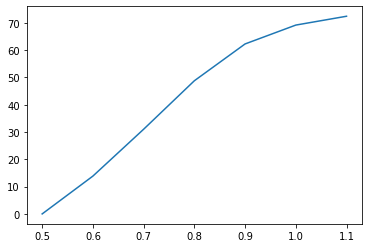

In [43]:
avg_hit_results = []
distances = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1]
for i in distances:
    ethane_dict = {'opls_135': 2, 'opls_140': 6}
    mols, system, surface_num, ts = track_molecules(gsdfile,
                                                    start_frame = 200,
                                                    stoich_dict=ethane_dict,
                                                    unitcell_repeats=[5,5,2],
                                                    active_site_threshold=i)
    avg_hit = np.mean([mol.hit_counter for mol in mols])
    avg_hit_results.append(avg_hit)

fig = plt.figure()
plt.plot(distances, avg_hit_results)

In [40]:
for mol in mols:
    print(mol.hit_counter)

18
28
0
29
8
26
21
19
26
31
34
19
27
26
12
27
30
29
36
29
27
41
27
2
31
27
32
15
28
31
13
28
28
10
28
17
28
11
27
3
8
23
27
28
25
29
38
22
21
26
28
29
26
20
38
27
14
32
30
17
33
30
31
26
22
36
23
22
26
24
29
30
23
32
33
19
30
24
33
6
33
9
28
27
29
28
19
20
28
16
28
30
40
29
18
28
22
21
23
22
29
30
14
34
24
26
31
27
27
29
6
22
26
32
26
7
14
30
26
20
18
18
32
0
29
37
29
0
2
18
20
13
5
22
22
19
30
23
25
25
13
22
23
21
17
15
25
17
23
27
14
23
35
7
17
28


In [34]:
act_site_dict = test_system.active_sites

In [37]:
print(len([key for key in act_site_dict]))

200


In [27]:
type(sorted_dict)

list

In [28]:
print(sorted_dict[199:400])

[(3878, ['Mo', 3895, False, array([-0.49123505, -0.35543364, -6.622166  ], dtype=float32)]), (4035, ['Mo', 4094, True, array([ 1.856755 ,  1.1541913, -6.2719464], dtype=float32)]), (4195, ['Nb', 4254, True, array([ 4.0052447,  1.1541913, -6.2719464], dtype=float32)]), (4355, ['Mo', 4414, True, array([-4.588715 ,  1.1541913, -6.2719464], dtype=float32)]), (4515, ['Mo', 4574, True, array([-2.440225 ,  1.1541913, -6.2719464], dtype=float32)]), (4675, ['Mo', 4734, True, array([-0.29173496,  1.1541913 , -6.2719464 ], dtype=float32)]), (4835, ['Mo', 4894, True, array([ 1.856755 ,  3.8189113, -6.2719464], dtype=float32)]), (4995, ['Mo', 5054, True, array([ 4.0052447,  3.8189113, -6.2719464], dtype=float32)]), (5155, ['Mo', 5214, True, array([-4.588715 ,  3.8189113, -6.2719464], dtype=float32)]), (5315, ['Mo', 5374, True, array([-2.440225 ,  3.8189113, -6.2719464], dtype=float32)]), (5475, ['Nb', 5534, True, array([-0.29173496,  3.8189113 , -6.2719464 ], dtype=float32)]), (5635, ['Nb', 5694, T

In [18]:
test_system.find_active_sites(test_system.system)

[0 1 2 3]
[    0     1     2 ... 63881 63882 63883]


In [18]:
file = "workspaces/msd-study/workspace/f5ba944635ae87e2feba02dd353f2ebc/output_traj.gsd"
gas_mols, system, num_surface, time = track_molecules(gsdfile=file,
                                                      start_frame=300,
                                                      stoich_dict = {'opls_135': 2, 'opls_140': 6})

In [19]:
msd_data, msd_std = average_system_msd(gas_mols, system.box, minimum_frames=2)

(-10.0, 100.0)

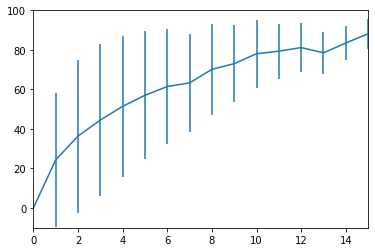

In [23]:
plt.errorbar(x=range(len(msd_data)), y=msd_data, yerr=msd_std)
plt.xlim(0, 15)
plt.ylim(-10,100)

In [47]:
ethane = gas_mols[1]
print(ethane.surface_frames)

[[0], [3], [6], [9], [12], [18, 20, 22, 23, 25], [28, 29], [34, 35, 37, 38], [42, 43, 44], [47, 49, 50], [54, 55, 57, 59], [62, 64], [67, 68, 69, 71, 73, 75, 76], [81, 82, 84, 86, 87, 88, 89, 91, 92], [113, 115], [122, 123, 125, 127], [132], [135], [144], [149, 150, 151, 152], [155, 156], [163], [167, 168, 170, 172, 173, 174, 175, 176], [179, 180, 181], [186, 187, 189], [193, 194], [197, 199]]


/home/chris/miniconda3/envs/analysis/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [48]:
for i in ethane.surface_pos[-5]:
    print(i)

[-2.6519003  2.6304588  5.479028 ]
[-4.024768   2.8416328  5.603003 ]
[-4.355161   2.6110694  5.5215235]
[ 4.5018144 -5.28151    5.5088477]
[ 3.952789  -4.0305567  5.602    ]
[ 3.4115686 -5.0850873  5.639367 ]
[ 1.3495997 -5.4513073  5.6595626]
[ 1.4077082 -4.9183397  5.506742 ]


/home/chris/miniconda3/envs/analysis/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [78]:
import mbuild as mb
surface = mb.load('/home/chris/cme/forks/rhaco-mc/rhaco/surfaces/5x5x2-pyridine.mol2')

/home/chris/miniconda3/envs/analysis/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [87]:
names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']
comps = ['C', 'CC', 'CCC', 'CCCC', 'CCCCC', 'CCCCCC', 'CCCCCCC', 'CCCCCCCC']
mbuild_comps = [mb.load(i, smiles=True) for i in comps]
z = max(surface.xyz[::,-1])
for idx, xyz_pos in enumerate(ethane.surface_pos[-5]):
    print(xyz_pos)
    new_pos = np.array([xyz_pos[0], xyz_pos[1], z])
    comp = mbuild_comps[idx]
    comp.name = names[idx]
    comp.translate_to = new_pos
    surface.add(comp)

[-2.6519003  2.6304588  5.479028 ]
[-4.024768   2.8416328  5.603003 ]
[-4.355161   2.6110694  5.5215235]
[ 4.5018144 -5.28151    5.5088477]
[ 3.952789  -4.0305567  5.602    ]
[ 3.4115686 -5.0850873  5.639367 ]
[ 1.3495997 -5.4513073  5.6595626]
[ 1.4077082 -4.9183397  5.506742 ]


/home/chris/miniconda3/envs/analysis/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [88]:
surface.visualize().show()

/home/chris/miniconda3/envs/analysis/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [71]:
comp.visualize()

/home/chris/miniconda3/envs/analysis/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

## Here, you can look at the same process but for individual molecules by changing the index in ethanes[]

### The plot of all individual MSDs are plotted along with the average.

CPU times: user 15.5 ms, sys: 0 ns, total: 15.5 ms
Wall time: 14.8 ms


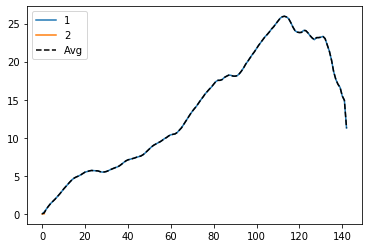

In [72]:
%%time
ethane = ethanes[3]
avg_msd, msd_std = average_mol_msd(ethane, box=system.box)
fig = plt.figure()
for idx, pos in enumerate(ethane.surface_pos):
    plt.plot(msd(pos, system.box), label=idx+1)
plt.plot(avg_msd, label='Avg', linestyle='--', c='k')
#plt.xlim(0, 5)
plt.legend()

**-------------------------------------------------**  

**Stuff I've removed, but don't want to delete yet:**

In [ ]:
def average_system_msd(molecules, system_box, minimum_frames=2):
    '''
    Lots of comments below for troubleshooting and following the code
    I'll summarize everything here later.
    '''
    # Iterate through each molecule
    # Iterate through each surface interaction of each molecule
    # Accumulate the length (num of frames) for each interaction
    surface_pos_lengths = []
    for mol in molecules:
        if len(mol.surface_pos) > 0: # If = 0; mol never reached the surface
            surface_pos_lengths.extend([len(pos_list) for pos_list in mol.surface_pos])
    surface_pos_lengths.sort() # Must go from smallest to largest
    
    # Remove any Lengths of one, the MSD values of a single point is 0
    # Set variable minimum_frames if we want to also discard other short periods
    surface_pos_lengths = [i for i in surface_pos_lengths if i >= minimum_frames]
    print('surface_pos_lengths list')
    print(surface_pos_lengths)
    # Remove duplicates, which is required when iterating and slicing msd_results
    # Create new variable because we still need info about the number of MSDs that are
    # of duplicate length
    surface_pos_lengths_set = list(OrderedDict.fromkeys(surface_pos_lengths))
    
    # Start with an array of zeros, equal to the length of the longest surface interaction time
    # Iterate over each molecule
    # Iterate over each of that molecule's surface interactions
    # Add the msd results from each surface interation to the msd_results array
    # msd_results is an accumulation of the MSD of any and all surface interactions
    msd_results = np.zeros(max(surface_pos_lengths), dtype=float)
    for mol in molecules:
        for positions in mol.surface_pos:
            if len(positions) > minimum_frames:
                mol_msd = msd(positions, system_box)
                mol_msd.resize(msd_results.shape) # resize so it can be added to msd_results
                msd_results += mol_msd  
    
    # Now we need to normalize msd_results, which to this point is just the summation
    # of all MSDs
    # average_msd = total_msd / N where N is the number of individual MSDs 
    # that contributed to that "bin" of msd_results
    
    # Slice msd_results between start_index and the next length (L)
    # Divide that slice by the # of MSDs that contributed to that bin
    # divide_by keeps track of the # of MSDs that contributed to each bin
    # divide_by starts with the length of surface_pos_lengths since the first bin
    # is an accumulation of every surface interaction MSD
    # After each iteration, divide_by is reduced by the count of L in surface_pos_lengths
    # Example:
        # 5 indiviudal MSDs of lengths 2, 2, 2, 5, and 12 frames each
        # lengths = [2, 2, 2, 5, 12]; divide_by starts at 5 and msd_results[0:2] is divided by 5
        # the next iteration, we want to divide msd_results[2:5] by 2
        # so divide_by = 5 - lengths.count(2) = 5-3 = 2
        # Finally, msd_results[5:12] is the result of only a single MSD, and divide_by = 1
        # NOTE: Not confident if standard deviation calculations here are the way to go
        # But, the standard deviation for each bin is calculated, then appended to 
        # standard_deviations in a way that standard_devations ends up having the same
        # length as msd_results.  The standard devations seem big, as of now they are calcualted
        # on the bin before it is normalzied, maybe it needs to happen after?
    start_index = 0
    divide_by = float(len(surface_pos_lengths)) 
    for L in surface_pos_lengths_set:
        if L == max(surface_pos_lengths): # the last iteration, slice to end of msd_results
            msd_results[start_index:] /= divide_by
        else: # slice between start_index and L
            msd_results[start_index:L] /= divide_by
        start_index = L
        divide_by -= surface_pos_lengths.count(L)
    return msd_results, standard_deviations

In [150]:
def average_mol_msd_verbose(molecule):
    if len(molecule.surface_pos) == 0:
        return [], []
    lengths = [len(pos_list) for pos_list in molecule.surface_pos]
    lengths.sort() # Must go from smallest to largest
    print(lengths)
    lengths_set = list(OrderedDict.fromkeys(lengths)) # Remove duplicates
    print(lengths_set)
    print()
        # example: [5, 12, 46] --> # of frames spent on surface/used in msd calc
    msd_results = np.zeros(max(lengths), dtype=float)
        # Add everything to msd_results
        # take care of normalization and std. dev in next step
    for positions in molecule.surface_pos:
        mol_msd = msd(positions)
        mol_msd.resize(msd_results.shape) # Resize so we can add to msd_results
        msd_results += mol_msd
        
    standard_deviations = []
    start_index = 0
    divide_by = float(len(molecule.surface_pos))
    for L in lengths_set:
        print("Length = {}".format(L))
        if L == max(lengths):
            print("Last Iteration")
            print("Indices = {}:".format(start_index))
            print("Dividing by {}".format(divide_by))
            num_data_points = len(msd_results[start_index:])
            std_dev = np.std(msd_results[start_index:])
            standard_deviations += num_data_points * [std_dev]
            standard_deviations.append(np.std(msd_results[start_index:]))
            msd_results[start_index:] /= divide_by
            break
        else:
            print('Indices = {}:{}'.format(start_index, L))
            print("Dividing by {}".format(divide_by))
            print('---------------')
            print(msd_results[start_index:L])
            num_data_points = len(msd_results[start_index:L])
            std_dev = np.std(msd_results[start_index:L])
            standard_deviations += num_data_points * [std_dev]
            standard_deviations.append(np.std(msd_results[start_index:L]))
            msd_results[start_index:L] /= divide_by
            print(msd_results[start_index:L])
            print('----------------')
        print()
        start_index = L
        divide_by -= lengths.count(L)
    return msd_results, standard_deviations

In [ ]:
standard_types = ['Te', 'Mo', 'V', 'Nb', 'O']
other_types = [i for i in system.particles.types if i not in standard_types]
system_ids = [p for p in system.particles.typeid]
Mo_indices = np.where([i == system.particles.types.index("Mo") for i in system_ids])[0]
type_indices = np.where(np.isin(system.particles.types, ['Mo']) == True)[0]
ethane_indices = np.where(np.isin(system_ids, type_indices) == True)[0]
print(len(Mo_indices))
print(len(ethane_indices))

In [ ]:
'''
import mbuild as mb

atom_type_dict = {'opls_135': 'C', 'opls_140': 'H', 'opls_145': 'c', 'opls_146': 'H'}
compound = mb.Compound()
for atom_type, pos in zip(benzene_types, benzene_mol_pos):
    species = atom_type_dict[atom_type]
    if species != 'H':
        mb_atom = mb.Compound(name=species, pos=pos)
        compound.add(mb_atom)
compound.add_bond([compound[0], compound[1]])
compound.add_bond([compound[1], compound[2]])
compound.add_bond([compound[2], compound[3]])
compound.add_bond([compound[3], compound[4]])
compound.add_bond([compound[4], compound[5]])
compound.add_bond([compound[5], compound[0]])
'''

In [ ]:
array = np.stack(ethane.surface_instance_pos)
array2 = np.vstack(ethane.surface_instance_pos)
array3 = np.hstack(ethane.surface_instance_pos)
array4 = np.stack(np.array(ethane.surface_instance_pos)[:, np.newaxis])

system_ids = [p for p in system.particles.typeid]
Mo_indices = np.where([i == system.particles.types.index("Mo") for i in system_ids])[0]
Mo_z_pos = system.particles.position[Mo_indices][::,-1]
print(np.max(Mo_z_pos) - np.min(Mo_pos))
system_ids2 = [p for p in system2.particles.typeid]
Mo_indices2 = np.where([i == system2.particles.types.index("Mo") for i in system_ids])[0]
Mo_z_pos2 = system2.particles.position[Mo_indices][::,-1]
print(np.max(Mo_z_pos2) - np.min(Mo_z_pos2))

In [ ]:
'''
def msd(molecule, box=system.box, mode='window'):
    positions = np.stack(np.array(molecule.surface_pos[0:60])[:, np.newaxis])
    mol_msd = freud.msd.MSD(box, mode)
    mol_msd.compute(positions)
    return mol_msd
'''

In [136]:
def surface_msd(gsdfile, atoms_per_mol, z_cutoff):
    f = gsd.pygsd.GSDFile(open(gsdfile, "rb"))
    t = gsd.hoomd.HOOMDTrajectory(f)
    
    gas = Gas(t[0])
    ethanes = gas.molecules(atoms_per_mol)
    surface_molecules = []
    time_steps = []

    for frame in t:
        pos = [e.center_xyz(frame) for e in ethanes if e.center_xyz(frame)[-1] < z_cutoff]
        surface_molecules.append(len(pos))
        time_steps.append(frame.configuration.step)
        
    fig = plt.figure()
    plt.plot(time_steps, surface_molecules)
    f.close()
    return surface_msd

In [329]:
@property
def atom_indices(self):
    indices = np.where(molecules == self.molecule_id)[0]
    return indices

def find_molecules(snap, atoms_per_mol=8):
    molecules = snap_bond_graph(snap)
    mol_count_dict = Counter(molecules)
    molecule_ids = []
    for key in mol_count_dict:
        if mol_count_dict[key] == atoms_per_mol:
            molecule_ids.append(key)
    return molecules, molecule_ids

def grouper(iterable):
    prev = None
    group = []
    for item in iterable:
        if not prev or item - prev <= 2:
            group.append(item)
        else:
            yield group
            group = [item]
        prev = item
    if group:
        yield group